## Post 방식 크롤링

목표 : 한국금거래소의 일별 금 가격 전체 데이터를 수집(2008 ~ 현재)하여 시각화하고,  
시기별 특정 이벤트를 annotation하여 가격 변동과의 관계를 살펴본다 

[한국금거래소](https://www.koreagoldx.co.kr/main/html.php?agencyCode=&htmid=goods/gold_list.html)

![gold_fluctuation](gold_fluctuation.png)

In [1]:
import urllib.request as req
import pandas as pd
import requests
from selenium import webdriver
import time
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import re

### 1-1. 웹 페이지 소스 데이터 가져오기 : requests

한국금거래소는 post 방식으로 클라이언트의 요청에 response 하므로 먼저 requests모듈을  
이용하여 head 정보 및 data params를 함께 전달하여 페이지 소스 획득이 가능한지 살펴본다



[requests docs](https://docs.python-requests.org/en/master/user/quickstart/)

In [2]:
# 금 시세 테이블이 있는 url
url_target = 'https://www.koreagoldx.co.kr/main/html.php?agencyCode=&htmid=goods/gold_list.html'

[header 및 payload]

In [833]:
header = {'User-Agent':'Mozilla/5.0'}

In [834]:
payload = {"srchDt": "ALL", "type": "Au", "dataDateStart": "2008.03.11", "dataDateEnd": "2021.05.06"}

[헤더와 페이로드 포함한 페이지 요청 및 response]

In [835]:
rr = requests.post(url_target, headers = header, data = payload)

[응답 페이지 소스 파싱하기]

In [837]:
soup_test = BeautifulSoup(rr.content, 'html.parser')

In [839]:
print(soup_test.prettify())

<!DOCTYPE doctype html>
<html>
 <head>
  <title>
   한국금거래소 - 대한민국 금거래의 중심
  </title>
  <meta content="IE=edge" http-equiv="X-UA-Compatible"/>
  <meta content="text/html; charset=utf-8" http-equiv="Content-Type">
   <meta content="한국금거래소" name="author"/>
   <meta content="오늘의 금시세(금값시세), 은시세, 금매입, 관련 시세 정보 제공으로 투명한 거래에 앞장서고 있습니다.." name="description"/>
   <meta content="금시세,금값,금값시세, 금매입, 국제금값,은값,은시세,골드바,실버바, 금, 한국금, 포나인, 고가매입, 조폐공사, 금괴, 투자, 오늘의금시세, 금테크, 재테크, 선물, 금화, 은화, 은테크," name="keywords"/>
   <meta content="MTYyMDM3OTY4NjIyMTMwNTI3MDEyMzE4Nzc3NjQwNzY4Njg4OTM0MjY5" name="csrf-token"/>
   <meta content="website" property="og:type"/>
   <meta content="한국금거래소" property="og:title"/>
   <meta content="https://www.koreagoldx.co.kr/data/common/snsRepresentImage.jpg" property="og:image"/>
   <meta content="https://www.koreagoldx.co.kr/main/html.php?agencyCode=&amp;htmid=goods/gold_list.html" property="og:url"/>
   <meta content="대한민국 금거래의 중심" property="og:description"/>
   <meta content="ko_K

헤더와 payload를 포함하여 페이지를 요청하였으나 우리가 필요한 테이블 데이터는  
html에 포함되어 있지 않으며 자바스크립트로 동적 구성되어 있다.

`<!-- 시세조회 스크립트 -->` 윗 부분 `<div id="example-table">` 확인

**<u>이런 경우 selenium을 이용하여 동적 크롤링하면 우리가 보는 웹 페이지의 소스 정보  
모두를 얻어올 수 있다.</u>**

### 1-2. 웹 페이지 소스 데이터 가져오기 : selenium

In [3]:
from selenium import webdriver

In [19]:
# 크롬 드라이버 구동 및 객체 생성
driver = webdriver.Chrome('D:/private/chrome/chromedriver.exe')

In [20]:
url = 'https://www.koreagoldx.co.kr/main/html.php?agencyCode=&htmid=goods/gold_list.html'

구동한 크롬드라이버의 get() 메서드에 url을 전달하여 페이지 요청 및 응답 받음

In [21]:
driver.get(url)

구동 중인 크롬브라우저에서 해당 웹페이지의 필요 정보 클릭  
--> **css selector 활용하여 `전체` 클릭**

In [22]:
all_element = driver.find_element_by_css_selector('#contents > div.sub_content > div > div.service_cont > div.clear > ul.graph_dt_buttons > li:nth-child(6) > label')

In [23]:
all_element.click()

[필요 데이터 접근 가능여부 확인]  
응답 받은 페이지 소스 정보에서 find_element_by_class_name() 이용하여 필요 데이터 수집 가능한지 확인

In [850]:
data_test = driver.find_element_by_class_name('tabulator-table')

In [851]:
data_test.text

'2021.05.07284,000263,000189,400146,000\n2021.05.06282,000261,500188,300145,200\n2021.05.05279,500260,500187,600144,600\n2021.05.04280,500260,500187,600144,600\n2021.05.03278,500260,000187,200144,300\n2021.05.01276,000259,500186,900144,100\n2021.04.30273,500258,000185,800143,200\n2021.04.29276,000259,500186,900144,100\n2021.04.28275,000258,500186,200143,500\n2021.04.27275,500259,500186,900144,100\n2021.04.26276,500260,000187,200144,300\n2021.04.24277,000260,000187,200144,300\n2021.04.23278,500260,500187,600144,600\n2021.04.22279,000260,500187,600144,600\n2021.04.21276,500259,000186,500143,800'

위와 같이 `find_element_by_class_name('tabulator-table')`에 접근했을 때 첫 페이지의 시세 테이블에 있는  
모든 데이터 15개 수집됨

이제 페이지를 넘겨가며 모든 데이터를 수집하면 된다

페이지 넘기기는 `>` next page 버튼을 활용하기로 결정

[next page 클릭 확인]  
css_selector : #example-table > div.tabulator-footer > span > button:nth-child(4)

In [852]:
click_element = driver.find_element_by_css_selector('#example-table > div.tabulator-footer > span > button:nth-child(4)')

In [853]:
click_element.click()

### [전체 데이터 수집]

In [14]:
import time

In [13]:
int(driver.find_element_by_id('tatalMarket').text)

4029

In [17]:
page_num = np.ceil(int(driver.find_element_by_id('tatalMarket').text)/15)

In [18]:
page_num

269.0

In [24]:
text = ""
i = 1
while i < (page_num+1):
    data_test = driver.find_element_by_class_name('tabulator-table')
    text += data_test.text + '\n'
    click_element = driver.find_element_by_css_selector('#example-table > div.tabulator-footer > span > button:nth-child(4)')
    click_element.click()
    time.sleep(2)
    print("{}페이지 수집 중".format(i))
    i = i + 1
    if i == page_num:
        print("마지막 페이지")

1페이지 수집 중
2페이지 수집 중
3페이지 수집 중
4페이지 수집 중
5페이지 수집 중
6페이지 수집 중
7페이지 수집 중
8페이지 수집 중
9페이지 수집 중
10페이지 수집 중
11페이지 수집 중
12페이지 수집 중
13페이지 수집 중
14페이지 수집 중
15페이지 수집 중
16페이지 수집 중
17페이지 수집 중
18페이지 수집 중
19페이지 수집 중
20페이지 수집 중
21페이지 수집 중
22페이지 수집 중
23페이지 수집 중
24페이지 수집 중
25페이지 수집 중
26페이지 수집 중
27페이지 수집 중
28페이지 수집 중
29페이지 수집 중
30페이지 수집 중
31페이지 수집 중
32페이지 수집 중
33페이지 수집 중
34페이지 수집 중
35페이지 수집 중
36페이지 수집 중
37페이지 수집 중
38페이지 수집 중
39페이지 수집 중
40페이지 수집 중
41페이지 수집 중
42페이지 수집 중
43페이지 수집 중
44페이지 수집 중
45페이지 수집 중
46페이지 수집 중
47페이지 수집 중
48페이지 수집 중
49페이지 수집 중
50페이지 수집 중
51페이지 수집 중
52페이지 수집 중
53페이지 수집 중
54페이지 수집 중
55페이지 수집 중
56페이지 수집 중
57페이지 수집 중
58페이지 수집 중
59페이지 수집 중
60페이지 수집 중
61페이지 수집 중
62페이지 수집 중
63페이지 수집 중
64페이지 수집 중
65페이지 수집 중
66페이지 수집 중
67페이지 수집 중
68페이지 수집 중
69페이지 수집 중
70페이지 수집 중
71페이지 수집 중
72페이지 수집 중
73페이지 수집 중
74페이지 수집 중
75페이지 수집 중
76페이지 수집 중
77페이지 수집 중
78페이지 수집 중
79페이지 수집 중
80페이지 수집 중
81페이지 수집 중
82페이지 수집 중
83페이지 수집 중
84페이지 수집 중
85페이지 수집 중
86페이지 수집 중
87페이지 수집 중
88페이지 수집 중
89페이지 수집 중
90페이지 수집 중
91페이지 수집 중
92페이지 수집

In [25]:
text

'2021.06.10292,000272,000195,900151,000\n2021.06.09293,000272,500196,200151,300\n2021.06.08293,000274,000197,300152,100\n2021.06.07292,000273,500197,000151,800\n2021.06.05292,000274,000197,300152,100\n2021.06.04291,000273,000196,600151,600\n2021.06.03294,500275,000198,000152,700\n2021.06.02292,500275,000198,000152,700\n2021.06.01293,500275,000198,000152,700\n2021.05.31293,500275,000198,000152,700\n2021.05.29294,500275,500198,400153,000\n2021.05.28293,500275,000198,000152,700\n2021.05.27294,500276,000198,800153,200\n2021.05.26295,500275,500198,400153,000\n2021.05.25293,000273,000196,600151,600\n2021.05.24295,000274,000197,300152,100\n2021.05.22295,000274,000197,300152,100\n2021.05.21293,000273,500197,000151,800\n2021.05.20295,000273,500197,000151,800\n2021.05.19293,000272,500196,200151,300\n2021.05.18293,000272,500196,200151,300\n2021.05.17292,000272,000195,900151,000\n2021.05.15289,000268,000193,000148,800\n2021.05.14288,000267,000192,300148,200\n2021.05.13285,500266,000191,600147,700\

In [32]:
len(text.split("\n")[:-1])

4029

In [33]:
raw_data = text.split("\n")[:-1]

In [34]:
len(raw_data)

4029

In [35]:
raw_data[0][:10]

'2021.06.10'

In [39]:
raw_dict = {}
raw_dict.setdefault('date',[])
raw_dict.setdefault('buy',[])
raw_dict.setdefault('sell_24k',[])
raw_dict.setdefault('sell_18k',[])
raw_dict.setdefault('sell_14k',[])


[]

In [40]:
for data in raw_data:
    raw_dict['date'].append(data[:10])
    raw_dict['buy'].append(re.findall('\d+,\d{3}', data[10:])[0])
    raw_dict['sell_24k'].append(re.findall('\d+,\d{3}', data[10:])[1])
    raw_dict['sell_18k'].append(re.findall('\d+,\d{3}', data[10:])[2])
    raw_dict['sell_14k'].append(re.findall('\d+,\d{3}', data[10:])[3])

In [41]:
raw_dict

{'date': ['2021.06.10',
  '2021.06.09',
  '2021.06.08',
  '2021.06.07',
  '2021.06.05',
  '2021.06.04',
  '2021.06.03',
  '2021.06.02',
  '2021.06.01',
  '2021.05.31',
  '2021.05.29',
  '2021.05.28',
  '2021.05.27',
  '2021.05.26',
  '2021.05.25',
  '2021.05.24',
  '2021.05.22',
  '2021.05.21',
  '2021.05.20',
  '2021.05.19',
  '2021.05.18',
  '2021.05.17',
  '2021.05.15',
  '2021.05.14',
  '2021.05.13',
  '2021.05.12',
  '2021.05.11',
  '2021.05.10',
  '2021.05.08',
  '2021.05.07',
  '2021.05.06',
  '2021.05.05',
  '2021.05.04',
  '2021.05.03',
  '2021.05.01',
  '2021.04.30',
  '2021.04.29',
  '2021.04.28',
  '2021.04.27',
  '2021.04.26',
  '2021.04.24',
  '2021.04.23',
  '2021.04.22',
  '2021.04.21',
  '2021.04.20',
  '2021.04.19',
  '2021.04.17',
  '2021.04.16',
  '2021.04.15',
  '2021.04.14',
  '2021.04.13',
  '2021.04.12',
  '2021.04.10',
  '2021.04.09',
  '2021.04.08',
  '2021.04.07',
  '2021.04.06',
  '2021.04.05',
  '2021.04.03',
  '2021.04.02',
  '2021.04.01',
  '2021.03.31',


In [42]:
raw_dict.keys()

dict_keys(['date', 'buy', 'sell_24k', 'sell_18k', 'sell_14k'])

In [43]:
raw_df = pd.DataFrame(raw_dict)

In [44]:
raw_df

,date,buy,sell_24k,sell_18k,sell_14k
0,2021.06.10,"292,000","272,000","195,900","151,000"
1,2021.06.09,"293,000","272,500","196,200","151,300"
2,2021.06.08,"293,000","274,000","197,300","152,100"
3,2021.06.07,"292,000","273,500","197,000","151,800"
4,2021.06.05,"292,000","274,000","197,300","152,100"
...,...,...,...,...,...
4024,2008.03.17,"138,050","107,500","88,687","69,359"
4025,2008.03.15,"133,650","106,000","87,450","68,391"
4026,2008.03.14,"130,020","102,000","84,150","65,810"
4027,2008.03.13,"128,370","100,500","82,912","64,842"


In [45]:
# 데이터 저장
raw_df.to_csv('examples/gold.csv', index = False)

데이터 불러오기

In [3]:
raw_df = pd.read_csv('gold.csv')

순금의 살 때/팔 때 가격 추이를 살펴보기 위해 date, buy, sell_24k 3개의 컬럼만 선택

In [4]:
gold24k = raw_df[['date', 'buy', 'sell_24k']]

가격을 수치 데이터로 변환하기 위해 콤마 제거 및 타입 변경

In [5]:
temp_re = lambda x:x.replace(",","")

In [10]:
gold24k[['buy','sell_24k']] = gold24k[['buy','sell_24k']].applymap(temp_re)

C:\Users\admin\Anaconda3\lib\site-packages\pandas\core\frame.py:3494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [13]:
gold24k[['buy','sell_24k']] = gold24k[['buy','sell_24k']].astype('int')

In [14]:
gold24k.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4029 entries, 0 to 4028
Data columns (total 3 columns):
date        4029 non-null object
buy         4029 non-null int32
sell_24k    4029 non-null int32
dtypes: int32(2), object(1)
memory usage: 63.1+ KB


In [51]:
# 가격 데이터 타입 확인
gold24k['buy'][0]

292000

오브젝트 타입인 날짜의 날짜형 변환을 위해 datetime 모듈의 datetime.strp() 메서드 적용

In [52]:
gold24k['date'][0]

'2021.06.10'

In [53]:
datetime.strptime(gold24k['date'][0], '%Y.%m.%d')

datetime.datetime(2021, 6, 10, 0, 0)

In [54]:
date_gold = [datetime.strptime(date, '%Y.%m.%d') for date in gold24k['date']]

In [55]:
gold24k.head(4)

,date,buy,sell_24k
0,2021.06.10,292000,272000
1,2021.06.09,293000,272500
2,2021.06.08,293000,274000
3,2021.06.07,292000,273500


In [56]:
gold24k.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4029 entries, 0 to 4028
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      4029 non-null   object
 1   buy       4029 non-null   int32 
 2   sell_24k  4029 non-null   int32 
dtypes: int32(2), object(1)
memory usage: 63.1+ KB


In [57]:
# 날짜형 변환
gold24k['date'] = [datetime.strptime(date, '%Y.%m.%d') for date in gold24k['date']]

C:\Users\GIGABYTE\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### 시각화

C:\Users\GIGABYTE\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\GIGABYTE\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


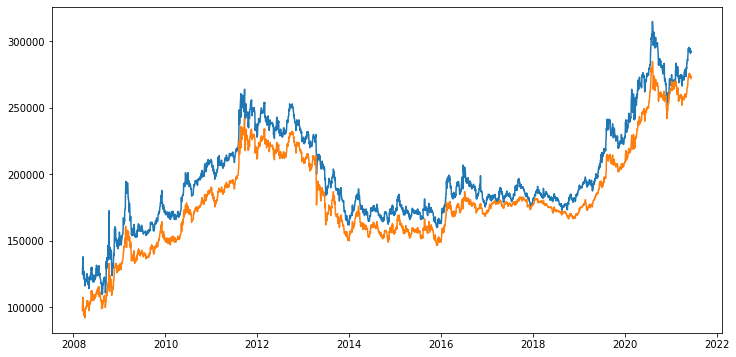

In [58]:
fig, ax = plt.subplots(figsize = (12,6))

ax.plot(date_gold, gold24k['buy'])
ax.plot(date_gold, gold24k['sell_24k'])
#ax.set_xlim([datetime(2007, 1, 1), datetime(2011, 1, 1)])
plt.show()

[이벤트 데이터]

In [15]:
crisis_data = [
    (datetime(2008, 3, 13), 'Bear Stearns Fails'),
    (datetime(2008, 9, 15), 'Lehman Bankruptcy'),
    (datetime(2012, 12, 19), '18th President Election'),
    (datetime(2017, 5, 9), '19th President Election'),
    (datetime(2020, 2, 12), 'COVID-19 by WHO')
]

In [18]:
gold24k.head()

,date,buy,sell_24k
0,2021-05-07,284000,263000
1,2021-05-06,282000,261500
2,2021-05-05,279500,260500
3,2021-05-04,280500,260500
4,2021-05-03,278500,260000


In [18]:
gold24k2 = gold24k.copy()

annotation의 좀더 손쉬운 적용을 위해 date 컬럼을 인덱스로 변환

In [19]:
gold24k2.set_index('date', inplace = True)

In [20]:
gold24k2.head(3)

,buy,sell_24k
date,,
2021.06.10,292000,272000
2021.06.09,293000,272500
2021.06.08,293000,274000


In [21]:
# sorted index 필요
gold24k2.asof(gold24k['date'][0])

ValueError: asof requires a sorted index

### [시각화 최종]

asof() 메서드 적용을 위해 gold24k2 데이터프레임을 날짜 인덱스에 대해 오름차순 정렬한다

In [87]:
gold24k3 = gold24k2.sort_index(ascending = True)

In [88]:
gold24k3.head(3)

,buy,sell_24k
date,,
2008-03-12,125180,97600
2008-03-13,128370,100500
2008-03-14,130020,102000


In [89]:
gold24k3['buy'].asof(datetime(2008,3,13))

128370

In [39]:
import matplotlib.font_manager as fm

font_path = 'C:\\WINDOWS\\Fonts\\gulim.ttc'

font_name = fm.FontProperties(fname = font_path).get_name()

plt.rcParams['font.family'] = font_name

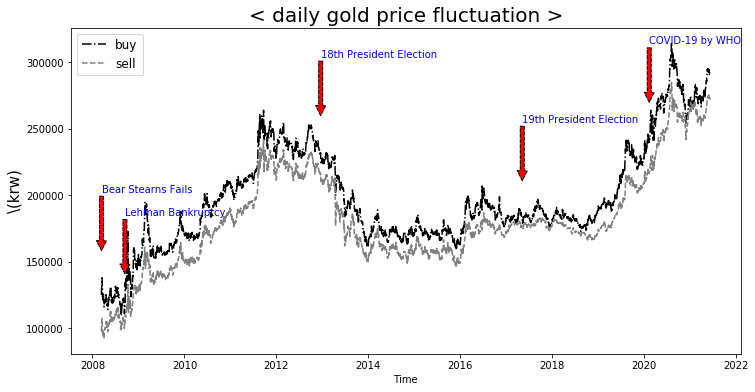

In [94]:
fig, ax = plt.subplots(figsize = (12,6))

ax.plot(gold24k3.index, gold24k3['buy'], c = 'k', ls = '-.', label = 'buy')
ax.plot(gold24k3.index, gold24k3['sell_24k'], c='gray', ls = '--', label = 'sell')

for date, event in crisis_data:
    ax.annotate(event, xy=(date, gold24k3['buy'].asof(date) + 30000),
                xytext=(date, gold24k3['buy'].asof(date) + 80000),
                arrowprops=dict(facecolor='red', headwidth=10, width=4,
                                headlength=10, ls = '--'),
                horizontalalignment='left', verticalalignment='top', c='b', fontsize = 10)
#ax.set_xlim([datetime(2007, 1, 1), datetime(2011, 1, 1)])
ax.set_title('< daily gold price fluctuation >', fontsize = 20)
ax.set_xlabel('Time')
ax.set_ylabel("\\(krw)", fontsize = 15)
ax.legend(loc = 2, fontsize = 12)
plt.show()